       tconst     nconst  category          primaryName  \
0   tt0093191  nm0092290     actor            Curt Bois   
1   tt0093191  nm0004486     actor           Bruno Ganz   
2   tt0093191  nm0000694  director          Wim Wenders   
3   tt0093191  nm0761420     actor          Otto Sander   
4   tt0093191  nm0231652   actress    Solveig Dommartin   
5   tt0074084  nm0078116   actress    Francesca Bertini   
8   tt0074084  nm0000934  director  Bernardo Bertolucci   
11  tt0074084  nm0000367     actor     Gérard Depardieu   
14  tt0074084  nm0000134     actor       Robert De Niro   
17  tt0074084  nm0761212   actress      Dominique Sanda   
20  tt0094315  nm0001273   actress         Lillian Gish   
21  tt0094315  nm0000012   actress          Bette Davis   
22  tt0094315  nm0815433   actress          Ann Sothern   
23  tt0094315  nm0001637     actor        Vincent Price   
24  tt0094315  nm0000755  director     Lindsay Anderson   

                             knownForTitles  averageRat

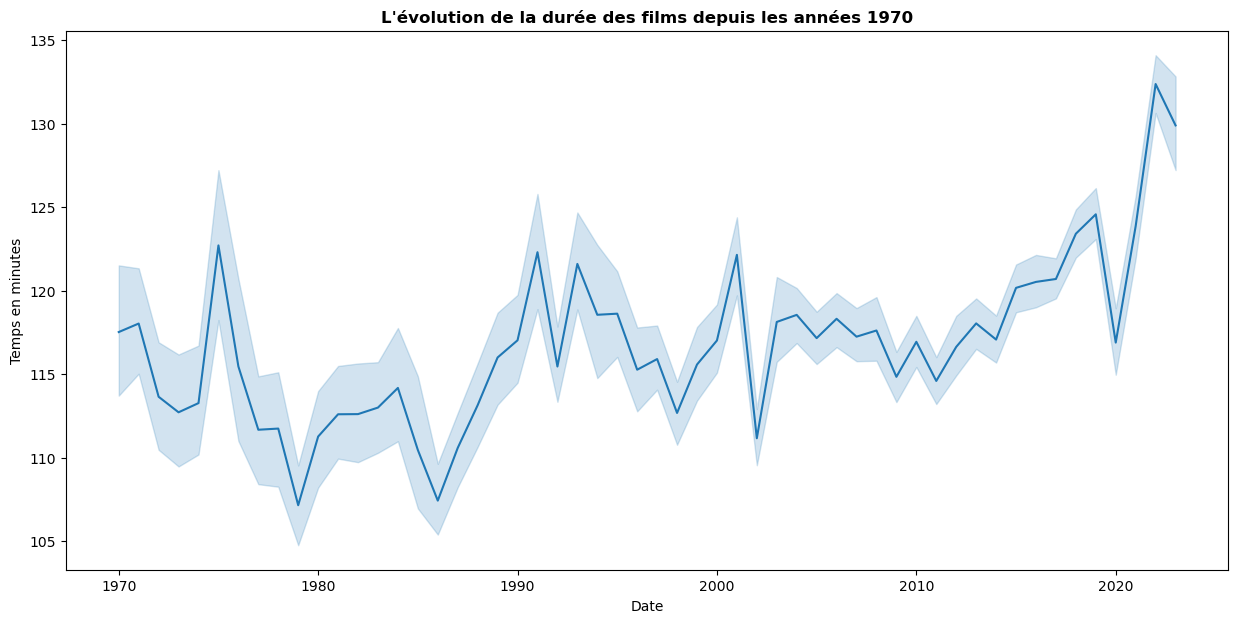

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

# Télécharger toutes les BDD
name_basics = pd.read_csv("https://datasets.imdbws.com/name.basics.tsv.gz", sep = "\t", low_memory = False, na_values=["\\N", "nan"])
title_akas = pd.read_csv("https://datasets.imdbws.com/title.akas.tsv.gz", sep = "\t", low_memory = False, na_values=["\\N", "nan"])
title_basics = pd.read_csv("https://datasets.imdbws.com/title.basics.tsv.gz", sep = "\t", low_memory = False, na_values=["\\N", "nan"])
title_crew = pd.read_csv("https://datasets.imdbws.com/title.crew.tsv.gz", sep = "\t", low_memory = False, na_values=["\\N", "nan"])
title_episode = pd.read_csv("https://datasets.imdbws.com/title.episode.tsv.gz", sep = "\t", low_memory = False, na_values=["\\N", "nan"])
title_principals = pd.read_csv("https://datasets.imdbws.com/title.principals.tsv.gz", sep = "\t", low_memory = False, na_values=["\\N", "nan"])
title_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", sep = "\t", low_memory = False, na_values=["\\N", "nan"])

# errors = "coerce" permet aux valeurs qui ne peuvent pas être convertie en int ou float de les remplacer en NaN.
#Utilisez la méthode pandas to_numeric pour convertir les valeurs de la colonne en nombres. Cette méthode va essayer de convertir toutes les valeurs de la colonne en nombres, 
#en supprimant toutes les chaînes de caractères. Les chaînes de caractères qui ne peuvent pas être converties en nombres seront remplacées par des valeurs NaN.
def convert_to_int(df_colonne,value_fill):
    df_colonne = pd.to_numeric(df_colonne, errors="coerce").fillna(value_fill)
    return df_colonne

#Utiliser la fonction pour convertir la colonne en question
title_basics["runtimeMinutes"] = convert_to_int(title_basics["runtimeMinutes"], 0)


# On effectue tous les filtres sur chaque BDD pour ne garder que ce qu'il nous intéresse.
movies = title_basics.loc[(title_basics["titleType"] == "movie") & (title_basics["isAdult"] == 0.0) & (title_basics['runtimeMinutes'] >= 60.0) & (title_basics['startYear'] >= 1970.0)]
title_akas = title_akas.loc[title_akas["region"] == "FR"] 
title_principals = title_principals.loc[title_principals["category"].isin(["actor", "actress","director"])]
title_ratings = title_ratings.loc[(title_ratings['numVotes'] > 3000) & (title_ratings['averageRating'] >= 7.0)]

# On effectue le nettoyage des différentes BDD avant fusion :

# renommer la colonne titleId dans la table title_akas en tconst pour que lors de la jointure il ne reste qu"une table tconst
title_akas.rename(columns = {'titleId':'tconst'}, inplace = True)

# permet de voir si il y a des duplicatats 
duplicates = title_akas.duplicated(subset=['tconst','title', 'language'], keep=False)

# permet de voir le nombre de duplicatats
duplicates.value_counts()

# Afficheer les lignes des duplicatats
duplicate_rows = title_akas.loc[duplicates]
duplicate_rows

# Supprimer la deuxième ligne du duplicatat et ne garder que la première
title_akas = title_akas.drop_duplicates(subset=['tconst','title', 'region', 'types'], keep="first")

# Permet de savoir la moyenne des votes
title_ratings["numVotes"].mean()

# Créer une fonction "Exploration".
def observation(df):
    print(df.head(15))
    print(f"\n")
    print(df.isna().sum())
    print(f"\n")
    print(df.shape)
    print(f"\n")
    print(df.duplicated().value_counts())
    
# Nous allons fusionner les BDD entre elles
fusion1 = pd.merge(title_principals,
                   name_basics,
                   how = "inner",
                   left_on="nconst",
                   right_on="nconst")

fusion2 = pd.merge(fusion1,
                   title_ratings,
                   how = "inner",
                   left_on="tconst",
                   right_on="tconst")

fusion3 = pd.merge(fusion2,
                   movies,
                   how = "inner",
                   left_on="tconst",
                   right_on="tconst")

bdd_finale = pd.merge(fusion3,
                   title_akas,
                   how = "left",
                   left_on="tconst",
                   right_on="tconst")

# Refaire un deuxième nettoyage afin de garder que ce l'on souhaite utiliser

# Supression colonnes inutiles :
bdd_finale = bdd_finale.drop(["ordering_x",
                        "job",
                        "characters",
                        "birthYear",
                        "deathYear",
                        "endYear",
                        "ordering_y",
                        "title",
                        "region",
                        "language",
                        "types",
                        "attributes",
                        "isOriginalTitle",
                        "isAdult",
                        "primaryProfession"], axis=1)

# Voir si il y a des doublons + value counts True False
duplicata = bdd_finale.duplicated().value_counts()
duplicata

# Supprimer les doublons en ne gardant que la première ligne
bdd_finale = bdd_finale.drop_duplicates(keep = "first")

# Regarder si il y a des valeurs manquantes
bdd_finale.isna().sum()

#Les dimensions de la table finale
observation(bdd_finale)

# Le nombre de film au total
bdd_finale["tconst"].value_counts().count()

# Sauvegarde de la BDD finale format CSV pour que les autres personnes de l'équipe puisse travailler dessus. 
bdd_finale.to_csv("bdd_filtré_final.tsv", sep="\t", index = False)

# KPI permettant de voir l'évolution de la durée des films depuis 1970

plt.figure(figsize=(15, 7))
sns.lineplot(data=bdd_finale, x='startYear', y='runtimeMinutes')
plt.title("L'évolution de la durée des films depuis les années 1970", fontweight="bold")
plt.ylabel("Temps en minutes")
plt.xlabel("Date")

#Pour les 6100 films :
# Je crée un df qui contient uniquement les genres en colonnes
df_genres = bdd_finale['genres'].str.get_dummies(',')
# Voir combien il y a de films par genre
somme_genres = df_genres.sum()
# Je selectionne les 10 genres les plus 'populaires' dans notre selection pour ensuite crée les KPI que je souhaite sortir plus bas.
top_10_genres = somme_genres.sort_values(ascending=False).head(10)

#Pour 1000 et 100 :

# On récupere les 100 et 1000 films les mieux notés
top_100_films = bdd_finale.sort_values(by='averageRating', ascending=False).head(100)
top_1000_films = bdd_finale.sort_values(by='averageRating', ascending=False).head(1000)

# On met 1 genre par colonne
top_100_genres = top_100_films['genres'].str.get_dummies(',')
top_1000_genres = top_1000_films['genres'].str.get_dummies(',')

# On fait la somme des genres  et on affiche les 100 / 1000 premiers
somme_100_genres = top_100_genres['genres'] = top_100_genres.sum()
somme_1000_genres = top_1000_genres['genres'] = top_1000_genres.sum()
somme_100_genres = somme_100_genres.sort_values(ascending=False)
somme_1000_genres = somme_1000_genres.sort_values(ascending=False)


import plotly.express as px

# KPI permettant de voir les 6100 films les mieux notés par genre :

data = {'Genre': ['Drama', 'Comedy', 'Crime', 'Action', 'Romance', 'Adventure', 'Biography', 'Thriller', 'Documentary', 'Mystery'],
        'Count': [4286, 1818, 1166, 1077, 979, 696, 682, 669, 547, 396]}
df_10gnr = pd.DataFrame(data)
fig = px.bar(df_10gnr, x='Genre', y='Count', labels={'Genre': 'Genres', 'Count': 'Nombre de films'})
fig.update_layout(title={'text': 'Les 6100 meilleurs films par genre', 'x': 0.5, 'xanchor': 'center'})
fig.show()

# KPI permettant de voir les 1000 films les mieux notés par genre :

data = {
    'genres': ['Drama', 'Comedy', 'Action', 'Crime', 'Documentary', 'Romance', 'Adventure', 'Biography', 'Thriller', 'Mystery', 'Animation', 'History', 'Music', 'War', 'Sci-Fi', 'Fantasy', 'Family', 'Sport', 'Musical', 'Horror', 'News', 'Western'],
    'count': [675.0, 249.0, 188.0, 181.0, 136.0, 118.0, 111.0, 108.0, 104.0, 65.0, 61.0, 59.0, 51.0, 48.0, 43.0, 40.0, 40.0, 36.0, 19.0, 15.0, 5.0, 4.0]
}
df1000 = pd.DataFrame(data)
fig = px.bar(df1000, x='genres', y='count', labels={'count': 'nombre de films'})
fig.update_layout(title={'text': '1000 films par genres', 'x': 0.5, 'xanchor': 'center'})
fig.show()

# KPI permettant de voir les 100 films les mieux notés par genre :

data = {'Genre': ['Drama', 'Comedy', 'Action', 'Crime', 'Adventure', 'Thriller', 'Documentary', 'Mystery',
                  'Biography', 'Romance', 'Music', 'Fantasy', 'Musical', 'Sci-Fi', 'History', 'Family',
                  'Animation', 'Horror', 'War'],
        'Count': [68.0, 29.0, 21.0, 19.0, 12.0, 8.0, 8.0, 7.0, 7.0, 7.0, 6.0, 5.0, 5.0, 4.0, 4.0, 4.0, 3.0, 2.0, 2.0]}
df100 = pd.DataFrame(data)
fig = px.bar(df100, x='Genre', y='Count', labels={'Genre': 'Genres', 'Count': '100 films par genres'}, title='Genre Distribution')
fig.update_layout(title={'text': '100 films par genres', 'x': 0.5, 'xanchor': 'center'})
fig.show()